# Homework 4

### Problem 1

Dataset Structure:

Total Gaps, Gap#1, Gap#2, Gap#3, Gap#4, Gap#5

Gaps are in seconds. If a gap is not observed then the value for that column is set to -9.

In [1]:
import csv
from tabulate import tabulate
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np

data = []
with open(r'gapdata.txt', 'r') as data_file:
    for row in csv.reader(data_file, delimiter='\t'):
        data.append(row)
data = np.array(data)

all_gaps = [[float(gap_) for gap_ in row if float(gap_) != -9] for row in data[:, 1:]]
critical_gap = [sum(gap_)/len(gap_) for gap_ in all_gaps]

In [2]:
y = []
gap = []
vehicle = []
crit_gap = []

for vid, row in enumerate(data):
    for i, in_row in enumerate(row[1:]):
        if float(in_row) != -9:
            vehicle.append(vid)
            y.append(1 if not i else 0)  # only the 2nd column contains accepted gap
            gap.append(float(in_row))
            crit_gap.append(critical_gap[vid])

In [3]:
y = np.array(y)
gap = np.array(gap)
vehicle_id = np.array(vehicle)
crit_gap = np.array(crit_gap)

# Check if all variables are of the same length
len(y) == len(gap) and len(gap) == len(crit_gap) and len(crit_gap) == len(vehicle_id)

True

### Total number of gaps in the dataset

In [4]:
len(y)

436

### Response variables are Binary

$y \in \{ 0, 1 \} = \{ \text{"Rejected", "Accepeted"}\}$

### Explanatory Variables:
$x_1 = \text{Gap}$

$x_2 = \text{Vehicle id}$

$x_3 = \text{Critical Gap   (Mean of valid gaps for a vehicle, -9 is an invalid gap)}$

# View of the Data (1st 20 datapoints)

In [5]:
dataset = [["y", "intercept (x0)", "Gap (x1)", "Vehicle id (x2)", "Critical Gap (x3)"]]
for i in range(20):
    dataset.append([y[i], 1, gap[i], vehicle_id[i], crit_gap[i]])
print(tabulate(dataset, tablefmt='simple', stralign='center', headers="firstrow"))

  y    intercept (x0)    Gap (x1)    Vehicle id (x2)    Critical Gap (x3)
---  ----------------  ----------  -----------------  -------------------
  1                 1         3                    0              3.16667
  0                 1         3.5                  0              3.16667
  0                 1         3                    0              3.16667
  1                 1         8.5                  1              8.5
  1                 1         6                    2              6
  1                 1        11.5                  3              3.41667
  0                 1         6                    3              3.41667
  0                 1         1                    3              3.41667
  0                 1         1                    3              3.41667
  0                 1         0.5                  3              3.41667
  0                 1         0.5                  3              3.41667
  1                 1        10                 

In [19]:
x = np.array(list(zip(gap, vehicle_id, crit_gap)))

array([[  3.        ,   0.        ,   3.16666667],
       [  3.5       ,   0.        ,   3.16666667],
       [  3.        ,   0.        ,   3.16666667],
       ...,
       [ 16.        , 200.        ,  16.        ],
       [ 25.        , 201.        ,  25.        ],
       [ 15.5       , 202.        ,  15.5       ]])

In [7]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [8]:
X = sm.add_constant(x)

glm_logit = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.logit()))
result_logit = glm_logit.fit()
stats_logit = result_logit.summary()
# print(stats_logit)

In [9]:
glm_probit = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.probit()))
result_probit = glm_probit.fit()
stats_probit = result_probit.summary()
stats_probit2 = result_probit.summary2()
# print(stats_probit)

In [10]:
glm_cloglog = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.cloglog()))
result_cloglog = glm_cloglog.fit()
stats_cloglog = result_cloglog.summary()
stats_cloglog2 = result_cloglog.summary2()
# print(stats_cloglog)

In [11]:
result_cloglog.predict(X);

In [12]:
def plot_roc_curve(fpr, tpr):
    fig, ax = plt.subplots(figsize=(12, 9))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def get_results(model, y, X):
    if model == "cloglog": 
        m = sm.GLM(y, X, family=sm.families.Binomial(link=sm.families.links.cloglog())).fit()
    else: 
        m = model(y, X).fit()
    print(m.summary2(), '\n')
    
    for i in [0.25, 0.50, 0.75]:
        y_hat = (m.predict(X) > i).astype('float')
        pt = confusion_matrix(y, y_hat, normalize=None)
        print(f"Confusion matrix for probability threshold = {i}:\n{pt}\n")
        dr = pt[1][1] / (pt[1][0] + pt[1][1])
        fp = pt[0][1] / (pt[0][0] + pt[0][1])
        print(f"Detection Rate = {pt[1][1]} / {(pt[1][0] + pt[1][1])}"
              f" = {round(dr, 2)}")
        print(f"False Positive Rate = {pt[0][1]} / {(pt[0][0] + pt[0][1])}"
              f" = {round(fp, 2)}\n\n")
    
    probs = m.predict(X)
    auc = roc_auc_score(y, probs)
    fpr, tpr, thresholds = roc_curve(y, probs)
    plot_roc_curve(fpr, tpr)
    
    print(f"Area Under Curve = {auc}")
    print('\n\n\n')
    return y_hat

Optimization terminated successfully.
         Current function value: 0.208213
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.699     
Dependent Variable: y                AIC:              189.5614  
Date:               2021-05-01 21:33 BIC:              205.8719  
No. Observations:   436              Log-Likelihood:   -90.781   
Df Model:           3                LL-Null:          -301.18   
Df Residuals:       432              LLR p-value:      6.9195e-91
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const     -3.4709     0.4683   -7.4120   0.0000   -4.3887   -2.5531
x1         0.8746     0.0983    8.9015   0.0000    0.6820 

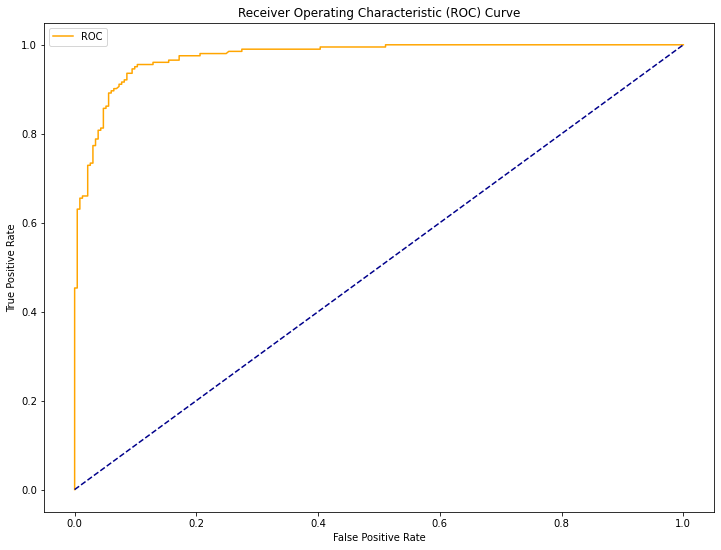

Area Under Curve = 0.9742066428465719




y_<class 'statsmodels.discrete.discrete_model.Logit'> = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0

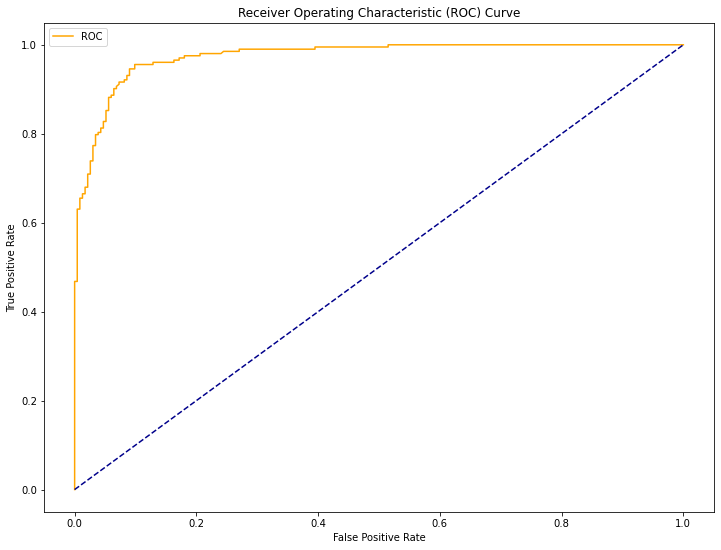

Area Under Curve = 0.974164358654517




y_<class 'statsmodels.discrete.discrete_model.Probit'> = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0

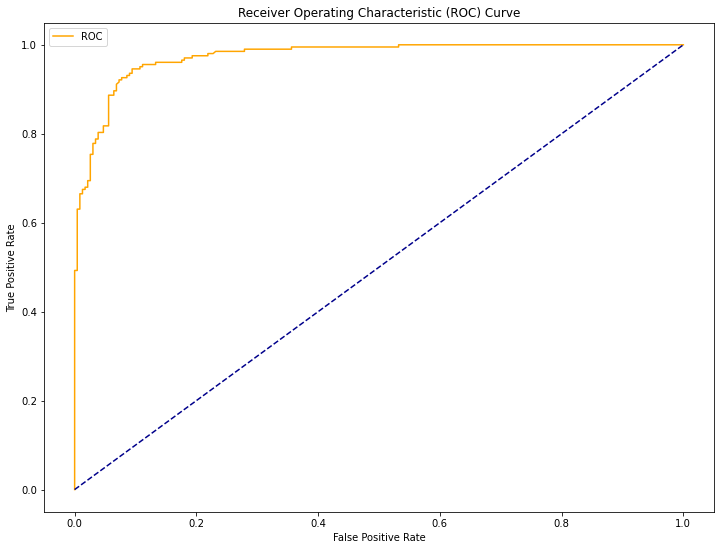

Area Under Curve = 0.9739317955982156




y_cloglog = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 

In [13]:
for model in [sm.Logit, sm.Probit, "cloglog"]:
    y_hat = get_results(model, y, X)
    print(f"y_{str(model)} = {[int(yy) for yy in y_hat]}")

               Results: Generalized linear model
Model:              GLM              AIC:            211.1736  
Link Function:      cloglog          BIC:            -2422.3679
Dependent Variable: y                Log-Likelihood: -101.59   
Date:               2021-05-01 21:33 LL-Null:        -301.18   
No. Observations:   436              Deviance:       203.17    
Df Model:           3                Pearson chi2:   2.80e+03  
Df Residuals:       432              Scale:          1.0000    
Method:             IRLS                                       
-----------------------------------------------------------------
         Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-----------------------------------------------------------------
const   -2.7416     0.3011   -9.1042   0.0000   -3.3318   -2.1514
x1       0.4767     0.0495    9.6395   0.0000    0.3798    0.5736
x2       0.0026     0.0022    1.2064   0.2277   -0.0016    0.0069
x3      -0.1866     0.0502   -3.7171   0.00

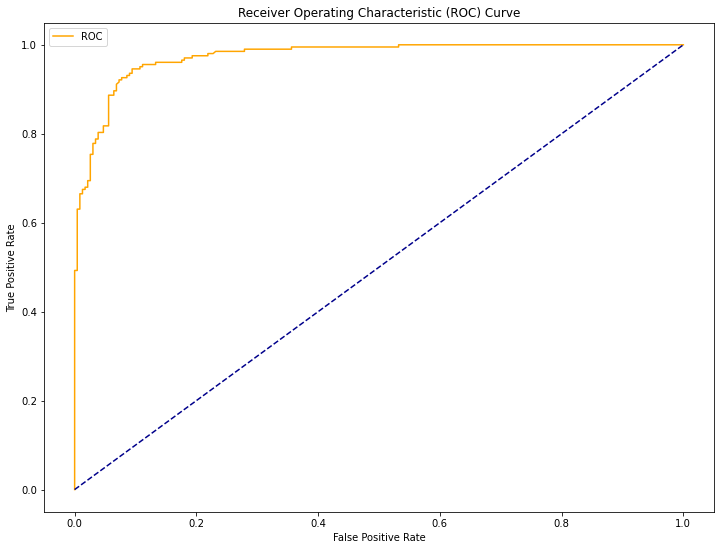

Area Under Curve = 0.9739317955982156






In [14]:
yhl = get_results('cloglog', y, X)

In [15]:
yhl = np.array(yhl, dtype=int)

In [16]:
yhl

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,

In [17]:
y = np.array(y, dtype=int)

In [18]:
y

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,